# Transfer learning with Tensorflow part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem

There are two main benefits:

1. Can leverage the existing neural network architecture proven to work on problem similar to our own
2. Can leverage a working neural network architecture which has already learned pattens on similar data to our own, then we can adapt those patterns to our own data

In [1]:
!nvidia-smi

Mon Apr 15 15:49:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Downloading and becoming one with data

In [2]:
# get data (10% of 10 food classes from food101)
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2024-04-15 15:49:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.207, 142.250.136.207, 142.250.148.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   161MB/s    in 1.0s    

2024-04-15 15:49:29 (161 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# Walk through directories
import os
for dirpath, dirname, filename in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dirname)} directories and {len(filename)} files present at {dirpath}")

There are 2 directories and 0 files present at 10_food_classes_10_percent
There are 10 directories and 0 files present at 10_food_classes_10_percent/train
There are 0 directories and 75 files present at 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 files present at 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 files present at 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 files present at 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 files present at 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 files present at 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 files present at 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 files present at 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 files present at 10_food_classes_10_percent/train/ramen
There are 0 directories 

Means `250` images of testing class means testing data remains same and `75` images of each food classes means only 10% of training data

## Creating the data loader

We'll use the `ImageDataGenerator` class to load in our images in batches

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


In [5]:
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size = IMAGE_SHAPE,
                                                         batch_size = BATCH_SIZE,
                                                         class_mode = 'categorical',
                                                         shuffle = True)
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size = IMAGE_SHAPE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run with our trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking Experiments with TensorBoard callback
* Model checkpoint with ModelCheckpoint
* Stopping a model from training (before it trains too long and overfits) with Early stoppping callback

In [6]:
# Create Tensorboard Callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    print(f"Saving tensorboard log files to {log_dir}")
    return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used Tensorflow to create our own models layer by layer from strach

Now we're goint to do a similar process except the majority of our model's layers are goint to come from TensorflowHub

We can access pretrained models On : https://tfhub.dev/

using Efficient net b0 feature vector:
https://www.kaggle.com/models/google/efficientnet/TensorFlow1/b0-feature-vector/1

In [7]:
efficientnet_url = "https://www.kaggle.com/models/google/efficientnet/TensorFlow1/b0-feature-vector/1"
#resnet model from keras.application

In [8]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet_v2

In [9]:
def create_model(model_url = efficientnet_url , num_classes= 10, resnet = False):
    """
    Takes a Tensorflow hub URL and create a keras Sequential model with it.

    Args:
        model_url(str): A Tensorflow hub feature extraction URL
        num_classes (int): Number of output neurons in the ourlayers default 10
        resnet(bool): Tells whether to import resnetv2 build model on that or not

    Returns:
        An uncompiled keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num-classes
    """

    if resnet:
        resnet_model = resnet_v2.ResNet50V2(weights = 'imagenet', include_top = False,
                                input_shape = IMAGE_SHAPE + (3,),
                                           pooling = 'avg')

        for layer in resnet_model.layers:
            layer.trainable = False

        model = tf.keras.Sequential([
            resnet_model,
            layers.Flatten(),
            layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
        ])

    else:
        feature_extractor_layer = hub.KerasLayer(model_url,
                                                trainable = False, #Freeze already learned patterns
                                                name = 'Feature-extraction_layer',
                                                input_shape = IMAGE_SHAPE + (3, ))

        # Create our own model
        model = tf.keras.Sequential([
            feature_extractor_layer,
            tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
        ])

    return model

In [10]:
## Creating and testing Resnet model
resnet_model = create_model(resnet = True)

94668760/94668760 [==============================] - 0s 0us/step


In [11]:
# compile the model
resnet_model.compile(loss = 'categorical_crossentropy',
                    optimizer = 'adam',
                    metrics = ['accuracy'])

In [12]:
resnet_history = resnet_model.fit(train_data_10_percent,
#                              steps_per_epoch = len(train_data_10_percent),
                             validation_data = test_data,
#                              validation_steps = len(test_data),
                             epochs = 5,
                             callbacks = [create_tensorboard_callback('tensorflow_hub',
                                                                     experiment_name = "resnet50v2")])

Saving tensorboard log files to tensorflow_hub/resnet50v2/20240415-154940
Epoch 1/5
24/24 [==============================] - 24s 612ms/step - loss: 1.8773 - accuracy: 0.3853 - val_loss: 1.2286 - val_accuracy: 0.5980
Epoch 2/5
24/24 [==============================] - 11s 459ms/step - loss: 0.9496 - accuracy: 0.7240 - val_loss: 0.9111 - val_accuracy: 0.7088
Epoch 3/5
24/24 [==============================] - 10s 434ms/step - loss: 0.6734 - accuracy: 0.8133 - val_loss: 0.8188 - val_accuracy: 0.7284
Epoch 4/5
24/24 [==============================] - 10s 434ms/step - loss: 0.5138 - accuracy: 0.8667 - val_loss: 0.7566 - val_accuracy: 0.7560
Epoch 5/5
24/24 [==============================] - 11s 482ms/step - loss: 0.4147 - accuracy: 0.8947 - val_loss: 0.7367 - val_accuracy: 0.7528


In [13]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 8s 105ms/step - loss: 0.7367 - accuracy: 0.7528


[0.7367384433746338, 0.7527999877929688]

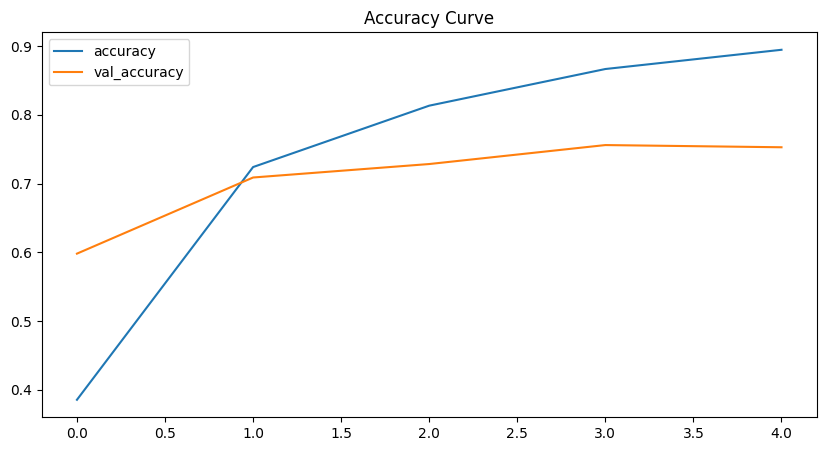

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(resnet_history.history)[['accuracy', 'val_accuracy']].plot(figsize = (10, 5));\
plt.title("Accuracy Curve");

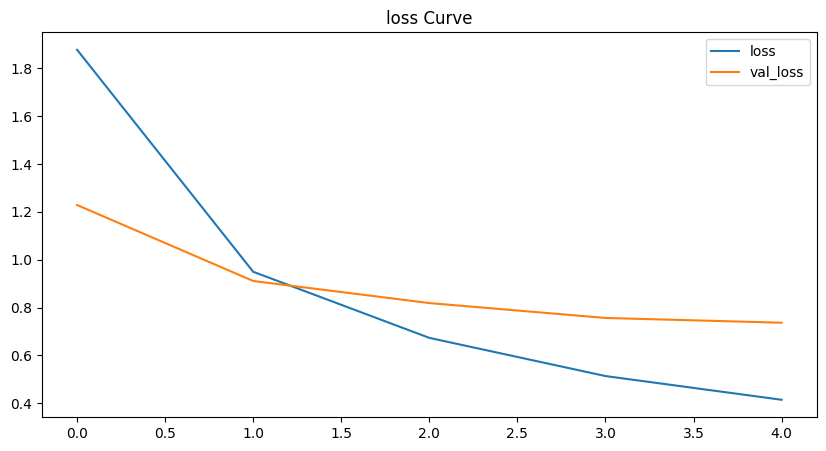

In [15]:
pd.DataFrame(resnet_history.history)[['loss', 'val_loss']].plot(figsize = (10, 5));
plt.title("loss Curve");

## Efficient net

In [16]:
efficient_model = create_model(resnet=False)

In [17]:
efficient_model.compile(loss = 'categorical_crossentropy',
                        optimizer = 'adam',
                        metrics=['accuracy'])

In [18]:
efficient_history = efficient_model.fit(train_data_10_percent,
                             steps_per_epoch = len(train_data_10_percent),
                             validation_data = test_data,
                             validation_steps = len(test_data),
                             epochs = 5,
                             callbacks = [create_tensorboard_callback('tensorflow_hub',
                                                                     experiment_name = "efficientnetb0")])

Saving tensorboard log files to tensorflow_hub/efficientnetb0/20240415-155103
Epoch 1/5
24/24 [==============================] - 20s 605ms/step - loss: 1.7783 - accuracy: 0.5000 - val_loss: 1.2491 - val_accuracy: 0.7364
Epoch 2/5
24/24 [==============================] - 10s 432ms/step - loss: 1.0225 - accuracy: 0.7760 - val_loss: 0.8463 - val_accuracy: 0.8108
Epoch 3/5
24/24 [==============================] - 10s 430ms/step - loss: 0.7356 - accuracy: 0.8387 - val_loss: 0.6863 - val_accuracy: 0.8392
Epoch 4/5
24/24 [==============================] - 10s 424ms/step - loss: 0.5933 - accuracy: 0.8747 - val_loss: 0.6054 - val_accuracy: 0.8496
Epoch 5/5
24/24 [==============================] - 10s 417ms/step - loss: 0.5017 - accuracy: 0.8920 - val_loss: 0.5549 - val_accuracy: 0.8568


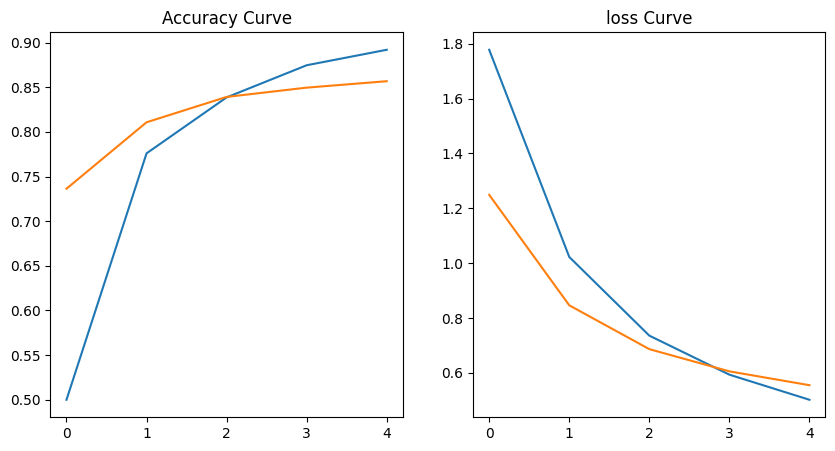

In [19]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.plot(pd.DataFrame(efficient_history.history)[['accuracy', 'val_accuracy']]);
plt.title("Accuracy Curve");

plt.subplot(1,2,2)
plt.plot(pd.DataFrame(efficient_history.history)[['loss', 'val_loss']]);
plt.title("loss Curve");

In [21]:
efficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature-extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [22]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


## Different types of transfer Learning

* "As is" Transfer learning -using an existing model with no changes what so ever (e.g. using image net model on 1000 image net classes)

* "Feature Extraction" - use the pretrained patterns of an existing model (e.g. EfficientNetB0 trained on image net) and adjusting the output layer for you own problem (e.g. 1000 Classes -> 10 classes of foood)

* "Fine-Tuning" Transfer learning - use the prelearned patterns of an existing model and fine-tune many or all of the underlying layers (including new output layer)

In [26]:
efficient_model.layers

## Comparing our models results using TensorBoard

In [27]:
# upload tensorboard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs Resnet50v2" \
    --description "Comparing two different TF hub feature extraction model architectures using 10% of the training data only" \
    --one_shot # going to exit the uploader

2024-04-15 16:05:29.360059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 16:05:29.360116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 16:05:29.361585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 16:05:30.325078: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

In [28]:
%load_ext tensorboard

In [30]:
!tensorboard --logdir "tensorflow_hub/"

2024-04-15 16:08:45.259266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 16:08:45.259317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 16:08:45.260571: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 16:08:46.250915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to 

In [31]:
!tensorboard dev list

2024-04-15 16:09:26.805273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 16:09:26.805334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 16:09:26.806902: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 16:09:28.216268: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard.dev Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to

can also use the Weights and Baises which is also a good option